<a href="https://colab.research.google.com/github/chiranjeet14/ML_Projects/blob/master/Competition/snake_detection_pretained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing dependencies and notebook gpu setup

In [ ]:
!pip uninstall -y tensorflow &> /dev/null
!pip install tensorflow &> /dev/null
!pip install --upgrade tensorflow &> /dev/null

## Importing dependencies for the project

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd
import numpy as np

%matplotlib inline
tf.__version__

# from tensorflow.keras.preprocessing import image_dataset_from_directory

'2.3.0'

## Data preprocessing

### Data download

In [ ]:
import pathlib
dataset_url = "https://he-s3.s3.amazonaws.com/media/hackathon/hackerearth-deep-learning-challenge-snake-breed-detection/identify-the-snake-breed-5-66d9a9f5/8a95c26e1bab11eb.zip"
data_dir = tf.keras.utils.get_file('snake_dataset', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/root/.keras/datasets/snake_dataset')

In [ ]:
data_dir = pathlib.Path('/root/.keras/datasets/dataset')
sub_directories = [x for x in data_dir.iterdir() if x.is_dir()]
print(sub_directories)

[PosixPath('/root/.keras/datasets/dataset/train'), PosixPath('/root/.keras/datasets/dataset/test')]


In [ ]:
train_folder = data_dir.joinpath('train')
test_folder = data_dir.joinpath('test')
print("Train dir : " + str(train_folder))
print("Test dir : " + str(test_folder))

Train dir : /root/.keras/datasets/dataset/train
Test dir : /root/.keras/datasets/dataset/test


In [ ]:
train_files = [e for e in train_folder.iterdir() if e.is_file()]
test_files = [e for e in test_folder.iterdir() if e.is_file()]
print("Train images count : " + str(len(train_files)))
print("Test images count : " + str(len(test_files)))

Train images count : 5508
Test images count : 2361


In [ ]:
train_csv_path = data_dir.joinpath('train.csv')
test_csv_path = data_dir.joinpath('test.csv')
df_train = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)
df_train.head()

,image_id,breed
0,a8b3ad1dde,nerodia-erythrogaster
1,8b492b973d,pantherophis-vulpinus
2,929b99ea92,thamnophis-sirtalis
3,bbac7385e2,pantherophis-obsoletus
4,ef776b1488,agkistrodon-contortrix


In [ ]:
unique_count = len(pd.unique(df_train['breed']))
print("No. of unique values : ",unique_count)

No. of unique values :  35


In [ ]:
for i in range(len(df_test['image_id'])):
    df_test['image_id'][i]=df_test['image_id'][i]+'.jpg'
df_test.head()

,image_id
0,7ede553357.jpg
1,3500b219e4.jpg
2,d43a78d6d9.jpg
3,1f36f26994.jpg
4,8cb85fc58e.jpg


## Create directories with class names

In [ ]:
import shutil
def move_file(source_with_filename,destination_with_filename):
  # shutil.move("path/to/current/file.foo", "path/to/new/destination/for/file.foo")
  try:
    os.makedirs(os.path.dirname(destination_with_filename), exist_ok=True)
    shutil.move(source_with_filename, destination_with_filename)
  except IOError as e:
    print("Unable to copy file. %s" % e)

In [ ]:
train_files = [e for e in train_folder.iterdir() if e.is_file()]
only_name = [os.path.basename(filename) for filename in train_files]

In [ ]:
for index, row in df_train.iterrows():
    source_with_filename = data_dir.joinpath('train', row['image_id'] + '.jpg')
    destination_with_filename = data_dir.joinpath('train', row['breed'], row['image_id'] + '.jpg')
    move_file(source_with_filename,destination_with_filename)

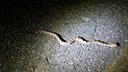

In [ ]:
crotalus = list(data_dir.joinpath('train','crotalus-horridus').glob('*.jpg'))
PIL.Image.open(str(crotalus[0]))

## Spilit images into train, val and test directories

In [ ]:
!pip3 install split-folders tqdm &> /dev/null
import splitfolders
directory = data_dir.joinpath('train')
splitfolders.ratio(directory, output="data", ratio=(.85, .15))

Copying files: 5508 files [00:00, 7051.16 files/s]


## Creating the base model and add some extra layers to adjust to our model

In [ ]:
# IMG_SIZE = (160, 160) # (img_height, img_width)
IMG_SIZE = (224, 224) # (img_height, img_width)
IMG_SHAPE = IMG_SIZE + (3,)
# base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet',
#                                                )

base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               )

In [ ]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
preds = tf.keras.layers.Dense(35,activation='softmax')(x)
model = tf.keras.models.Model(inputs=base_model.input,outputs=preds)

## Creating training and validation set

In [ ]:
BATCH_SIZE = 6

# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(#rescale = 1./255,
                                                                rotation_range=30,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range = 0.2,
                                                                zoom_range = 0.2,
                                                                horizontal_flip = True,
                                                                vertical_flip = True,
                                                                preprocessing_function=preprocess_input,
                                                                )

# valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
#                                                                preprocessing_function=preprocess_input,
#                                                                )
# validation and test images will be similar

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(#rescale = 1./255,
                                                               preprocessing_function=preprocess_input,
                                                               )

train_generator = train_datagen.flow_from_directory('data/train',
                                                    target_size=IMG_SIZE,
                                                    # color_mode='rgb',
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    )

validation_generator = test_datagen.flow_from_directory('data/val',
                                                        target_size=IMG_SIZE,
                                                        # color_mode='rgb',
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        shuffle=True,
                                                        )

test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                  directory=test_folder,
                                                  x_col="image_id",
                                                  y_col=None,
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode=None,
                                                  target_size=IMG_SIZE,
                                                  )

Found 4668 images belonging to 35 classes.
Found 840 images belonging to 35 classes.
Found 2361 validated image filenames.


## Training the model

In [ ]:
# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy'])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=0.1), loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
EPOCHS = 100

# Save the model according to the conditions  
# checkpoint = tf.keras.callbacks.ModelCheckpoint("mobilenet_v2.h5", monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
# early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto')

# # Training the model
# history = model.fit(train_generator,
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_data=validation_generator,
#                     validation_steps=STEP_SIZE_VALID,
#                     epochs=EPOCHS,
#                     callbacks = [checkpoint, early],
#                     )

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

## Fine tuning

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  780


In [ ]:
# base_model.trainable = True

base_model.trainable = False

# # Fine-tune from this layer onwards
# fine_tune_at = 600

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable =  False

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy'])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=0.1), loss='categorical_crossentropy', metrics = ['accuracy'])

# model.summary()
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# Save the model according to the conditions  
checkpoint = tf.keras.callbacks.ModelCheckpoint("inception_resnet_v2_pretrained_model.h5", monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto')

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS,
                    callbacks = [checkpoint, early],
                    )
model.save('model.h5')

Epoch 1/100
778/778 [==============================] - 74s 95ms/step - loss: 3.4029 - accuracy: 0.0936 - val_loss: 3.2344 - val_accuracy: 0.1536
Epoch 2/100
778/778 [==============================] - 71s 91ms/step - loss: 3.2138 - accuracy: 0.1395 - val_loss: 3.0066 - val_accuracy: 0.2048
Epoch 3/100
778/778 [==============================] - 71s 91ms/step - loss: 3.1034 - accuracy: 0.1650 - val_loss: 2.9332 - val_accuracy: 0.2202
Epoch 4/100
778/778 [==============================] - 69s 89ms/step - loss: 3.0132 - accuracy: 0.1823 - val_loss: 2.8681 - val_accuracy: 0.2060
Epoch 5/100
778/778 [==============================] - 70s 91ms/step - loss: 2.9683 - accuracy: 0.1902 - val_loss: 2.7281 - val_accuracy: 0.2595
Epoch 6/100
778/778 [==============================] - 69s 89ms/step - loss: 2.9206 - accuracy: 0.2054 - val_loss: 2.7151 - val_accuracy: 0.2512
Epoch 7/100
778/778 [==============================] - 69s 89ms/step - loss: 2.8898 - accuracy: 0.2095 - val_loss: 2.7048 - val_ac

### Using pre-trained weights to train model

In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None,
                                               )
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
preds = tf.keras.layers.Dense(35,activation='softmax')(x)
model = tf.keras.models.Model(inputs=base_model.input,outputs=preds)
model.load_weights("inception_resnet_v2_pretrained_model.h5")

base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy'])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=0.1), loss='categorical_crossentropy', metrics = ['accuracy'])

# model.summary()
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# Save the model according to the conditions  
checkpoint = tf.keras.callbacks.ModelCheckpoint("inception_resnet_v2_new_model.h5", monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto')

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS,
                    callbacks = [checkpoint, early],
                    )
model.save('model_new.h5')

Epoch 1/100
778/778 [==============================] - 134s 173ms/step - loss: 2.7940 - accuracy: 0.2361 - val_loss: 6.4513 - val_accuracy: 0.3048
Epoch 2/100
778/778 [==============================] - 131s 169ms/step - loss: 2.5824 - accuracy: 0.2798 - val_loss: 4.9041 - val_accuracy: 0.3298
Epoch 3/100
778/778 [==============================] - 131s 169ms/step - loss: 2.4630 - accuracy: 0.3063 - val_loss: 6.6216 - val_accuracy: 0.3357
Epoch 4/100
778/778 [==============================] - 131s 169ms/step - loss: 2.3867 - accuracy: 0.3196 - val_loss: 5.2788 - val_accuracy: 0.3417
Epoch 5/100
778/778 [==============================] - 132s 169ms/step - loss: 2.3573 - accuracy: 0.3284 - val_loss: 2.7807 - val_accuracy: 0.3595
Epoch 6/100
778/778 [==============================] - 132s 169ms/step - loss: 2.3040 - accuracy: 0.3436 - val_loss: 2.9064 - val_accuracy: 0.3667
Epoch 7/100
778/778 [==============================] - 132s 169ms/step - loss: 2.2481 - accuracy: 0.3515 - val_loss: 3

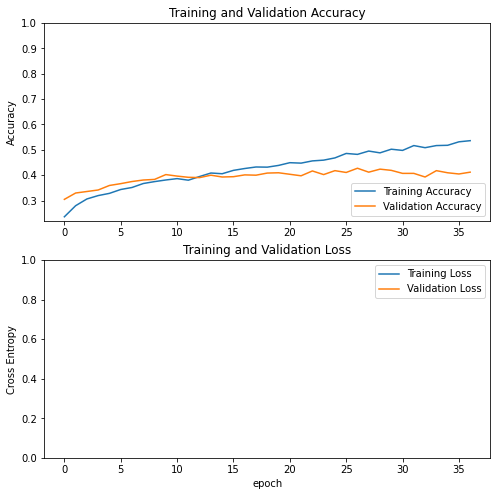

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Predicting on Test Data

In [ ]:
y_pred = model.predict_generator(test_generator,verbose=1)

2361/2361 [==============================] - 56s 24ms/step


In [ ]:
y_pred.shape

In [ ]:
y_pred_2 = np.argmax(y_pred,axis=1)

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in y_pred_2]

In [ ]:
test_name = df_test['image_id'].values

In [ ]:
sstring = '.jpg'
for index, name in enumerate(test_name):
        test_name[index] = test_name[index].replace(sstring, '')

In [ ]:
data = pd.DataFrame((zip(test_name,predictions)),columns=['image_id','breed'])

In [ ]:
data.to_csv('output.csv',index=False)

In [ ]:
df_demo = pd.read_csv('output.csv')
df_demo.head()

,image_id,breed
0,7ede553357,pantherophis-spiloides
1,3500b219e4,nerodia-sipedon
2,d43a78d6d9,pituophis-catenifer
3,1f36f26994,lampropeltis-triangulum
4,8cb85fc58e,pantherophis-alleghaniensis
